#  `lightweight` 💪🎯💪 

In [ ]:
!pip install opencv-python tqdm imutils -q

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 32.6MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 1.2MB 43.2MB/s 
     |████████████████████████████████| 194kB 51.3MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import imutils

import fastai
from fastai.vision.all import *
from fastai.basics import *
from matplotlib import pyplot as plt
import cv2
import pathlib
import ast
import random
from IPython.display import display, Markdown

print(f' Fastai {fastai.__version__}\nPytorch {torch.__version__}\n OpenCV {cv2.__version__}')
try:
  print(f'    GPU {torch.cuda.get_device_name(0)}')
  torch.cuda.device(0)
except: print("No GPU detected")

 Fastai 2.4
Pytorch 1.9.0+cu102
 OpenCV 4.1.2
    GPU Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 🤗 1. Get trial data from `gdrive`

In [ ]:
# Get test data from drive
!mkdir images
!cp -v "/content/drive/MyDrive/lightweight/data/frame143_alphapose.jpg" "./images"

'/content/drive/MyDrive/lightweight/data/frame143_alphapose.jpg' -> './images/frame143_alphapose.jpg'


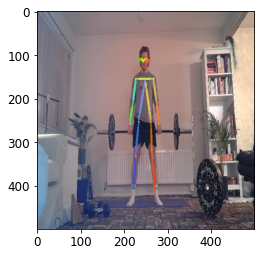

In [ ]:
# Open sample image
image = cv2.imread('images/frame143_alphapose.jpg', cv2.IMREAD_COLOR)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_im)
plt.show()

In [ ]:
# Get training data from drive
!mkdir data

!cp -v "/content/drive/MyDrive/lightweight/data/000_lightweight_n195_alphapose_small.zip" "data"
!unzip -q -d data data/000_lightweight_n195_alphapose_small.zip

imgs = (Path("data/000_lightweight_n195_alphapose_small")).ls()
print('Training set size:', len(imgs))

'/content/drive/MyDrive/lightweight/data/000_lightweight_n195_alphapose_small.zip' -> 'data/000_lightweight_n195_alphapose_small.zip'
Training set size: 195


In [ ]:

# Read in label metadata csv
!cp -v "/content/drive/MyDrive/lightweight/data/labels_n195.csv" "data"
path = Path('drive/My Drive/lightweight/data/000_lightweight_complete_n195_alphapose_small/')
df = pd.read_csv('data/labels_n195.csv')[['External ID', 'Label']].sort_values('External ID').drop_duplicates('External ID')

# Drop rows with no label 
print('  ▷', df.shape, 'total')
df = df[df.Label.str.len() > 2]
print('  ▷', df.shape, 'with labels')

# First row is video file
df = df.iloc[1:, :].copy().reset_index(drop=True)
df.head(2)

'/content/drive/MyDrive/lightweight/data/labels_n195.csv' -> 'data/labels_n195.csv'
  ▷ (196, 2) total
  ▷ (195, 2) with labels


,External ID,Label
0,02_luke_sunlight_frame1093.jpg,"{""objects"":[],""classifications"":[{""featureId"":""ckmhv16hb000d3a656jp8kr7j"",""schemaId"":""ckm84qik51epp0y9e5eia2gmd"",""title"":""What position is the lifter in?"",""value"":""what_position_is_the_lifter_in?"",""answer"":[{""featureId"":""ckmhv16hb000c3a653nebhmf6"",""schemaId"":""ckm84qils1eq00y9e7ezb82dq"",""title"":""02_deadliftDown"",""value"":""02_deadliftdown""}]}]}"
1,02_luke_sunlight_frame1125.jpg,"{""objects"":[],""classifications"":[{""featureId"":""ckmhv66nt003t3a65xso0ozdl"",""schemaId"":""ckm84qik51epp0y9e5eia2gmd"",""title"":""What position is the lifter in?"",""value"":""what_position_is_the_lifter_in?"",""answer"":[{""featureId"":""ckmhv66nt003s3a65jsnqybmt"",""schemaId"":""ckm84qils1eq00y9e7ezb82dq"",""title"":""02_deadliftDown"",""value"":""02_deadliftdown""}]}]}"


In [ ]:
%%time
# Extract label from json dict

labels = []
for r in df.iterrows():
  d = ast.literal_eval(r[1]['Label'])
  try: c = d['classifications'][0]['answer'][0]['title']
  except:
    try: c = d['classifications'][0]['answer']['title']
    except:
      c = 'missing'
      print('No label on', r[0])
  labels.append(c)

print(df.shape, len(labels))
df['classification'] = pd.Series(labels)
display(df[['External ID', 'classification']].tail(10))

No label on 120
(194, 2) 194


,External ID,classification
184,frame785.jpg,05_frontUp
185,frame801.jpg,05_frontUp
186,frame83.jpg,03_inMotion
187,frame842.jpg,05_frontUp
188,frame896.jpg,03_inMotion
189,frame898.jpg,03_inMotion
190,frame899.jpg,03_inMotion
191,frame93.jpg,02_deadliftDown
192,frame934.jpg,06_overheadPress
193,frame99.jpg,01_standing


CPU times: user 39.8 ms, sys: 646 µs, total: 40.4 ms
Wall time: 41.1 ms


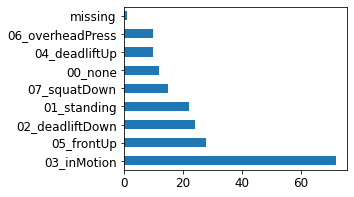

In [ ]:
df.classification.value_counts().plot(kind='barh', figsize=(4,3));

### 2. Dataloader `get` Functions

random: 0
data/000_lightweight_n195_alphapose_small/02_luke_sunlight_frame1093.jpg
(500, 500)
02_deadliftDown


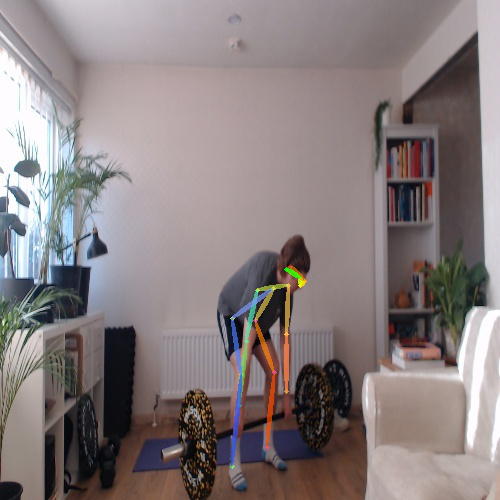

In [ ]:
df = df[df.classification!='missing'][['External ID', 'classification']]
dataset_path = Path('data/000_lightweight_n195_alphapose_small')

def get_x(f):
    # dataset_path = Path('data/000_lightweight_n173')
    return dataset_path/f"{f['External ID']}"

i = random.randint(0, 40)
print('random:', i)
row = df.iloc[i]
print(get_x(row))
im = PILImage.create(get_x(row))
print(im.shape)
print(row['classification'])
im.to_thumb(500)

In [ ]:
df['classifornication'] = df.classification.str.split('_').str[0].astype(int)

def get_y(f):
  #return f['classification']
  return ColReader('classifornication')

get_y(df.head(1))

ColReader -- {'cols': 'classifornication', 'pref': '', 'suff': '', 'label_delim': None}:
encodes: decodes: 

### 🧚 DataBlock

In [ ]:
# Transforms
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast(),
        Normalize.from_stats(*imagenet_stats)]

# Create gobbler
gobbler = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_x=ColReader(0, pref="/content/data/000_lightweight_n195_alphapose_small/"),
   get_y=ColReader(1), #, label_delim='_'),
   splitter=RandomSplitter(valid_pct=0.2, seed=-1),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),  # orig 224
   batch_tfms=tfms)


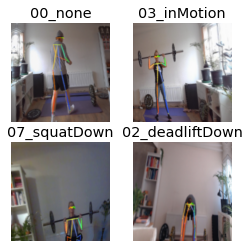

In [ ]:
# Batch size is passed in the data loader

bs = 16
dls = gobbler.dataloaders(df, bs=bs)
dls.show_batch(max_n=4, figsize=(4,4))


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
print(learn.loss_func)

print(f'▷ ({len(learn.dls.train.items)}) in training set')
print(f'▷ ({len(learn.dls.valid.items)}) in validation set')

print('\nVocab:\n', dls.vocab, '\n')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



FlattenedLoss of CrossEntropyLoss()
▷ (155) in training set
▷ (38) in validation set

Vocab:
 ['00_none', '01_standing', '02_deadliftDown', '03_inMotion', '04_deadliftUp', '05_frontUp', '06_overheadPress', '07_squatDown'] 



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# Valid/training proportions

dx = pd.DataFrame()
dx['valid'] = learn.dls.valid.items.classification.value_counts()
dx['valid_%'] = (100*learn.dls.valid.items.classification.value_counts(normalize=True)).round(1)
dx['train'] = learn.dls.train.items.classification.value_counts()
dx['train_%'] = (100*learn.dls.train.items.classification.value_counts(normalize=True)).round(1)
dx

,valid,valid_%,train,train_%
03_inMotion,12,31.6,60,38.7
01_standing,7,18.4,15,9.7
05_frontUp,5,13.2,23,14.8
07_squatDown,4,10.5,11,7.1
00_none,3,7.9,9,5.8
02_deadliftDown,3,7.9,21,13.5
06_overheadPress,2,5.3,8,5.2
04_deadliftUp,2,5.3,8,5.2


In [ ]:
print('batch size:', bs, '\n')
xb, yb = dls.one_batch()
print('x shape =', xb.shape, '\ny shape =', yb.shape)

# Output tensor
print('y =', yb)

batch size: 16 

x shape = torch.Size([16, 3, 224, 224]) 
y shape = torch.Size([16])
y = TensorCategory([1, 0, 1, 0, 0, 3, 1, 5, 3, 6, 2, 6, 5, 5, 0, 4], device='cuda:0')


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

print(learn.loss_func)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth



FlattenedLoss of CrossEntropyLoss()


CPU times: user 9.27 s, sys: 5.43 s, total: 14.7 s
Wall time: 1min 13s


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.002511886414140463)

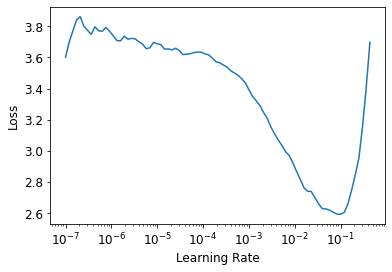

In [ ]:
%%time
learn.lr_find()

### Training Model

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
lr=1e-2
wd=1e-2
learn.fit_one_cycle(50, slice(lr), pct_start=0.9, wd=wd)

epoch,train_loss,valid_loss,error_rate,time
0,3.038222,5.646454,0.921053,00:01
1,2.905136,2.651055,0.736842,00:01
2,2.691857,2.098414,0.605263,00:01
3,2.597058,1.924189,0.605263,00:01
4,2.487499,1.792274,0.578947,00:01
5,2.415370,1.520850,0.368421,00:01
6,2.309658,1.267944,0.394737,00:01
7,2.205948,1.119921,0.421053,00:01
8,2.075882,1.053110,0.315789,00:01
9,1.895203,0.922220,0.236842,00:01


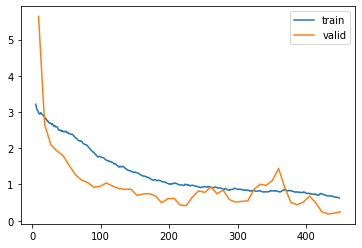

In [ ]:
learn.recorder.plot_loss() 

   top = ground truth
bottom = prediction


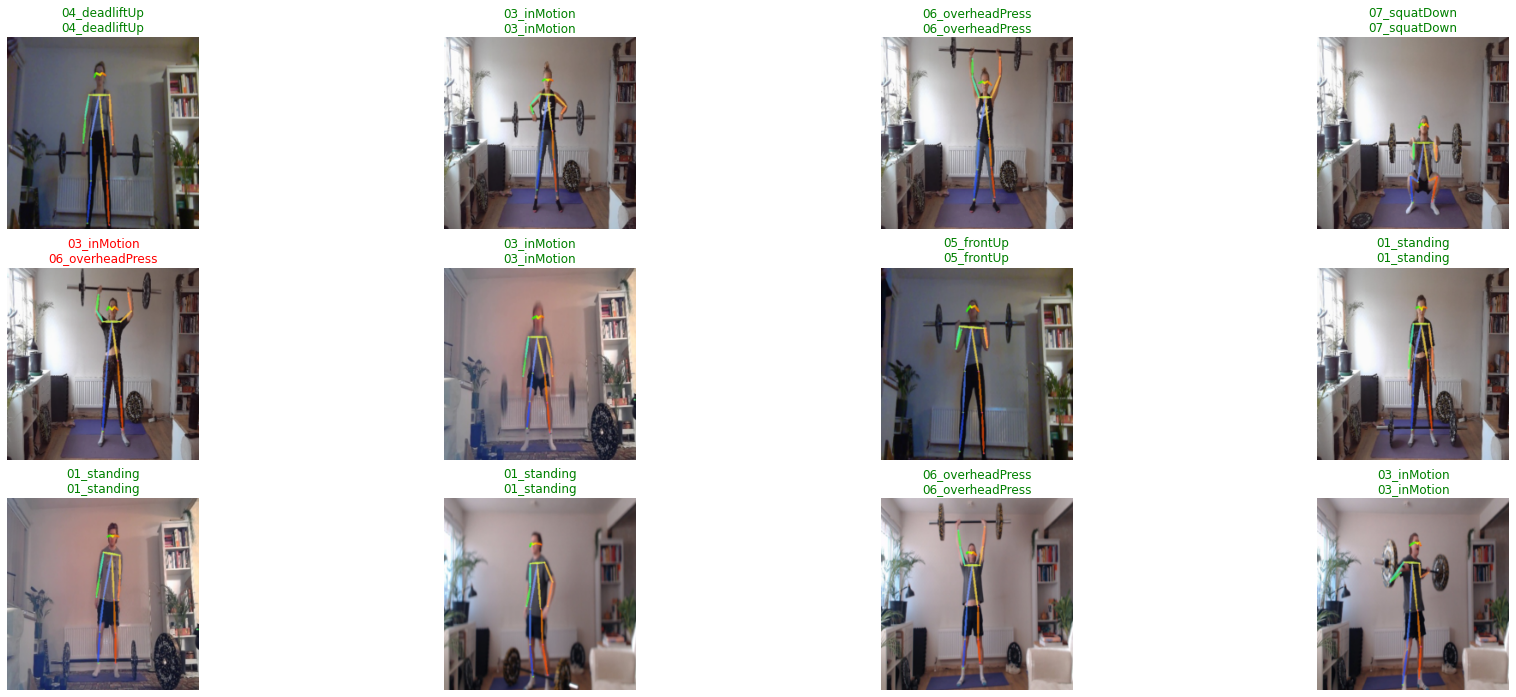

In [ ]:
print('   top = ground truth\nbottom = prediction')
learn.show_results(max_n=12, figsize=(30,12))

#### Interpreter

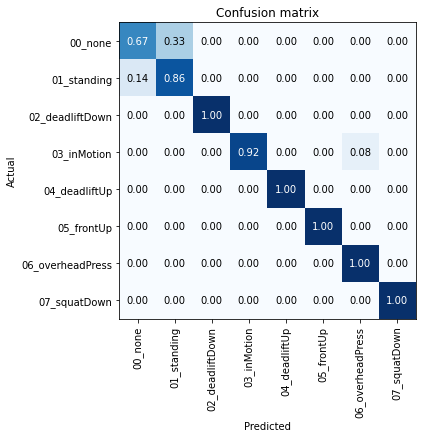

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(9, figsize=(6,6))

### Save/Load Model

In [ ]:
learn.export('lw_nb04_ap2.pkl')
!cp "lw_nb04_ap2.pkl" "/content/drive/MyDrive/lightweight/models"

# 🔴🎬 2. Test Model
* Testing inference speed
* Building util functions

In [ ]:
from fastai.vision.all import *

'/content/drive/MyDrive/lightweight/data/01_luke_premium/frame143.jpg' -> './images/frame143.jpg'


In [ ]:
#%%time
# Define learner `get functions` and import weights 

learn = load_learner('/content/drive/MyDrive/lightweight/models/lw_nb02.pkl')

mkdir: cannot create directory ‘images’: File exists
'/content/drive/MyDrive/lightweight/data/01_luke_premium/frame143.jpg' -> './images/frame143.jpg'


prediction:


## ▷ `04_deadliftUp (0.9194)`

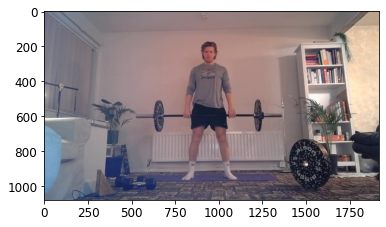

In [ ]:
# Test inference

!mkdir images
!cp -v "/content/drive/MyDrive/lightweight/data/01_luke_premium/frame143.jpg" "./images"
img_path = '/content/images/frame143.jpg'

out = learn.predict(img_path)

print('prediction:')
display(Markdown(f'## ▷ `{out[0]} ({max(out[2]):0.4f})`'))

# Display inline
image = cv2.imread('images/frame143.jpg', cv2.IMREAD_COLOR)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im)
plt.show()

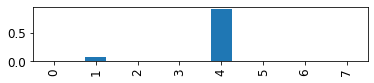

In [ ]:
pd.Series(out[2]).plot(kind='bar', figsize=(6,1));

In [ ]:
%%timeit
# inference test
out = learn.predict(img_path)

1 loop, best of 5: 314 ms per loop


#### Speed up `fastai2` inference
`muellerzr` https://forums.fast.ai/t/speeding-up-fastai2-inference-and-a-few-things-learned/66179/24

In [ ]:
!pip install fastinference -q

     |████████████████████████████████| 194kB 7.7MB/s 
     |████████████████████████████████| 12.8MB 230kB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 776.8MB 17kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
im_names = ['/content/images/frame143.jpg', '/content/images/frame143.jpg']

In [ ]:
type_tfms = [PILImage.create]
item_tfms = [Resize(224), ToTensor()]
type_pipe = Pipeline(type_tfms)
item_pipe = Pipeline(item_tfms)
norm = Normalize.from_stats(*imagenet_stats)
i2f = IntToFloatTensor()

batches = []
batch = []
outs = []
inps = []
k = 0

for im in im_names:
    batch.append(item_pipe(type_pipe(im)))
    k += 1
    if k == 50:
        batches.append(torch.cat([norm(i2f(b.cuda())) for b in batch]))
        batch = []
        k = 0

learn.model.eval()
with torch.no_grad():
    for b in batches:
        outs.append(learn.model(b))
        inps.append(b)

inp = torch.stack(inps)
out = torch.stack(outs)
dec = learner.dls.decode_batch((*tuplify(inp), *tuplify(out)))

In [ ]:
type_tfms = [PILImage.create]
item_tfms = [Resize(224), ToTensor()]
type_pipe = Pipeline(type_tfms)
item_pipe = Pipeline(item_tfms)
norm = Normalize.from_stats(*imagenet_stats)
i2f = IntToFloatTensor()


batches = []
batch = []
outs = []
inps = []
k = 0
for im in im_names:
    batch.append(item_pipe(type_pipe(im)))
    k += 1
    if k == 50:
        batches.append(torch.cat([norm(i2f(b.cuda())) for b in batch]))
        batch = []
        k = 0

learner.model.eval()
with torch.no_grad():
    for b in batches:
        outs.append(learner.model(b))
        inps.append(b)

inp = torch.stack(inps)
out = torch.stack(outs)
dec = learner.dls.decode_batch((*tuplify(inp), *tuplify(out)))

#### Fastinference example

In [ ]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [ ]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
o = learn.predict(fnames[0], with_input=False)
o

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


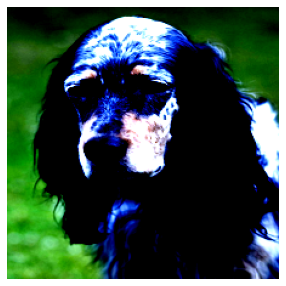

In [ ]:
imgs, probs, classes, clas_idx = learn.get_preds(dl=learn.dls.test_dl(fnames[:3]), with_input=True, with_decoded=True)
TensorImage(imgs[0]).show()

In [ ]:
probs[2]

tensor([3.7953e-07, 1.2897e-05, 1.6483e-07, 4.6039e-06, 1.2526e-06, 4.6261e-03, 4.4497e-09, 9.5633e-07, 1.6276e-06, 1.6149e-04, 1.7245e-07, 2.5702e-04, 6.4912e-06, 5.6977e-09, 1.7365e-02, 9.7423e-01,
        1.7141e-08, 4.2095e-06, 1.5826e-03, 2.6875e-05, 5.8835e-08, 5.7704e-05, 2.0705e-09, 2.3548e-04, 4.9759e-09, 8.7695e-09, 1.4349e-10, 1.2410e-06, 8.3018e-10, 2.7403e-06, 1.4965e-04, 1.2581e-03,
        5.5489e-10, 2.4913e-06, 4.7118e-06, 2.0021e-06, 3.1179e-06])

### CraftVision example

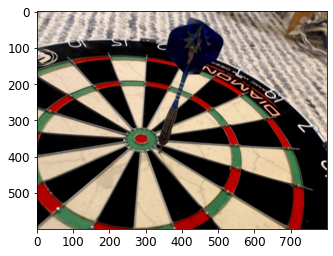

In [ ]:
# Open sample image
image = cv2.imread('images/Snapshot_20200310_10.JPG', cv2.IMREAD_COLOR)
RGB_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_im)
plt.show()

In [ ]:
imgs = (Path("images/")).ls()
imgs

(#1) [Path('images/Snapshot_20200310_10.JPG')]

In [ ]:
from fastai.vision.all import *

In [ ]:
#%%time
# Define learner `get functions` and import weights 

def get_x(f):
    return f"data/combine950/{f['External ID']}"

def get_mask(f):
    return f"data/{f['External ID']}"

def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

learn = load_learner('/content/drive/MyDrive/FlightVision/models/fv_nb016/export.pkl')

ModuleNotFoundError: ignored